# Cluster Peaks

Cluster peaks for each cell cluster and look for motifs.

In [ ]:
library(DESeq2)
library(ggplot2)
library(ggrepel)
library(reshape2)
library(parallel)

In [2]:
cts <- read.csv("../20200122_snapATAC/snapATAC_sessions/20200125_n76770/cluster_bulk_peakset_matrix/cluster.bulk.idr.cluster.counts.txt",sep="\t")
rownames(cts)=paste(cts$chr,cts$start,cts$end,sep='\t')
cts$chrom = NULL
cts$start = NULL
cts$end = NULL
head(cts, 2)
dim(cts)

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10,cluster11,cluster12,cluster13,cluster14,cluster15,cluster16,cluster17,cluster18
chr1 51459 51659,1,0,3,2,0,0,0,0,0,2,0,0,3,2,0,0,0,1
chr1 51689 51889,2,1,17,15,0,1,0,0,0,0,2,0,7,1,3,0,0,0


[1] 299032     18

In [3]:
cts = cts[rowSums(cts)>50, ]
dim(cts)

[1] 292377     18

In [4]:
# norm_cts = t(t(cts)/estimateSizeFactorsForMatrix(cts[rowSums(cts<50)==0, ]))
norm_cts = t(t(cts)/estimateSizeFactorsForMatrix(cts))

In [5]:
log_norm_cts = log10(1+norm_cts)

In [257]:
library(RColorBrewer)

In [258]:
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

In [266]:
pca = prcomp(t(log_norm_cts),center=TRUE,scale=FALSE)
pcs=data.frame(pca$x)
pcs$ID=rownames(pcs)
pcs$clust_num = as.numeric(lapply(strsplit(pcs$ID, 'cluster'), "[[",2 ))
var_explained=round(100*pca$sdev^2/sum(pca$sdev^2),2)
print(var_explained)

 [1] 48.60 20.75  7.44  4.91  3.90  3.53  2.54  1.89  1.34  1.01  0.95  0.76
[13]  0.63  0.55  0.49  0.43  0.30  0.00


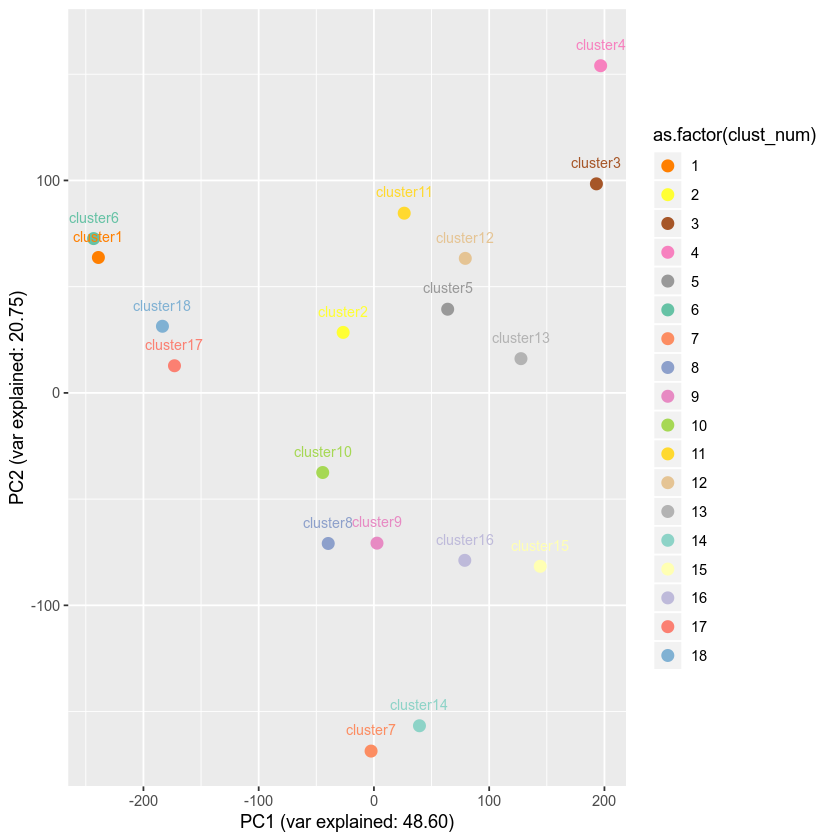

In [268]:
ggplot(data=pcs,aes(x=PC1,y=PC2,color=as.factor(clust_num),label=ID))+
geom_point(size=3)+
scale_colour_manual(values = col_vector[seq(50,67)]) +
geom_text(size=3, nudge_y=10)+
labs(x=sprintf("PC1 (var explained: %.2f)", var_explained[1]), y = sprintf("PC2 (var explained: %.2f)", var_explained[2]))

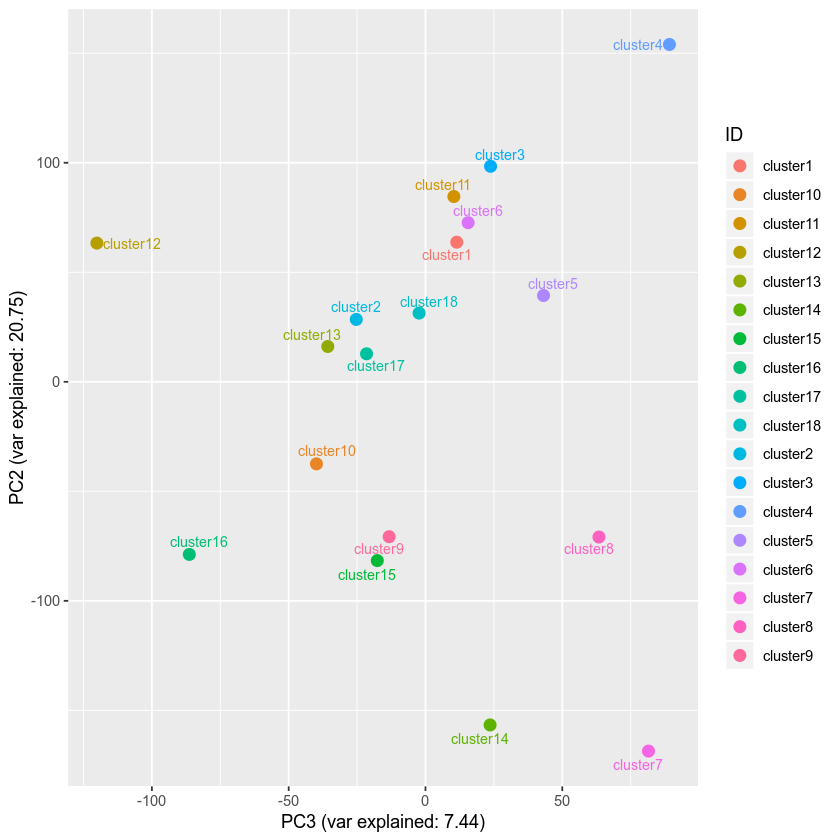

In [8]:
ggplot(data=pcs,aes(x=PC3,y=PC2,color=ID,label=ID))+
geom_point(size=3)+
geom_text_repel(size=3)+
labs(x=sprintf("PC3 (var explained: %.2f)", var_explained[3]), y = sprintf("PC2 (var explained: %.2f)", var_explained[2]))

## Diff Peaks

In [ ]:
library(edgeR)

In [11]:
data.use = cts
group = factor(seq(1,ncol(data.use)))
design = model.matrix(~group)
y = DGEList(counts=data.use, group=group)

In [12]:
# do pairwise comparisons and get union of top diff peaks
all_pairs = vector(mode = "list", length = ncol(cts)*(ncol(cts)-1)/2)
c = 1
for (i in seq(1,ncol(cts))) {
    if (i < ncol(cts)) {
        for (j in seq(i+1, ncol(cts))) {
            all_pairs[[c]] = c(i,j)
            c = c+1
        }
    }
}

PER_PAIR = 10000

get_diff <- function(i, all_pairs, y, per_pair) {
    et = exactTest(y, dispersion = 0.4^2, pair = all_pairs[[i]])         
    cur_diff_peaks = rownames(et$table[order(et$table$PValue)[1:per_pair],])        
}

diff_peaks_list = mclapply(seq(1, length(all_pairs)), 
                           get_diff, 
                           all_pairs=all_pairs, 
                           y=y,  
                           per_pair=PER_PAIR,
                           mc.cores=40)

In [13]:
diff_peak_set = unique(unlist(diff_peaks_list))
length(diff_peak_set)

[1] 152315

## Clustering

In [15]:
library(ClusterR)
library(viridis)
library(scales)

Loading required package: gtools
Loading required package: viridisLite

Attaching package: ‘scales’

The following object is masked from ‘package:viridis’:

    viridis_pal



In [132]:
cts_to_cluster = t(scale(t(log_norm_cts[, ])))

In [158]:
# ADD RAND SEED - not required

km_mb = MiniBatchKmeans(cts_to_cluster, 
                        batch_size = 1000,
                        clusters=20,
                        num_init = 10, 
                        verbose = FALSE)

In [159]:
# reorder based on hierarchical clustering
pr_mb = predict_MBatchKMeans(cts_to_cluster, km_mb$centroids)
# distance    = dist(km_mb$centroids)
distance    = dist(t(scale(t(km_mb$centroids))))
cluster     = hclust(distance, method="ward")
dendrogram  = as.dendrogram(cluster)
rowInd = rev(order.dendrogram(dendrogram))
pr_mb = order(rowInd)[pr_mb]

The "ward" method has been renamed to "ward.D"; note new "ward.D2"


In [160]:
table(pr_mb)

pr_mb
    1     2     3     4     5     6     7     8     9    10    11    12    13 
17468 23547  7356 18094 22638 11043  8588 10424 27377 11450 20395 18099 29780 
   14    15    16    17    18    19    20 
 8368  9891 13120  6795 10274 10810  6860 

In [161]:
cts_clustered = cts_to_cluster[order(pr_mb),]
head(cts_clustered, 2)

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10,cluster11,cluster12,cluster13,cluster14,cluster15,cluster16,cluster17,cluster18
chr1 1024437 1025223,-1.342646,-0.3118383,0.9507566,1.6899537,0.9874862,-1.221787,0.4006875,1.760456,-0.3381220,-0.8139349,-0.2531076,-0.6064351,0.4948267,-0.2661436,0.5695853,0.7819611,-1.049938,-1.431761
chr1 1073979 1074637,-1.438084,-0.2348015,0.9268777,0.8821158,0.3414903,-1.376011,-0.1658567,1.731629,0.2479527,-0.1443504,-0.3914848,-0.8817715,0.8707364,0.3897313,1.4226704,0.6072186,-1.372119,-1.415943


In [162]:
# order columns
col_distance = dist(t(cts_clustered))
col_cluster = hclust(col_distance, method="ward")
col_dendrogram = as.dendrogram(col_cluster)
colInd = rev(order.dendrogram(col_dendrogram))

cts_clustered_col_ordered = cts_clustered[, colInd]
head(cts_clustered_col_ordered, 2)

The "ward" method has been renamed to "ward.D"; note new "ward.D2"


,cluster12,cluster5,cluster11,cluster2,cluster10,cluster9,cluster15,cluster13,cluster16,cluster14,cluster7,cluster8,cluster4,cluster3,cluster18,cluster17,cluster6,cluster1
chr1 1024437 1025223,-0.6064351,0.9874862,-0.2531076,-0.3118383,-0.8139349,-0.3381220,0.5695853,0.4948267,0.7819611,-0.2661436,0.4006875,1.760456,1.6899537,0.9507566,-1.431761,-1.049938,-1.221787,-1.342646
chr1 1073979 1074637,-0.8817715,0.3414903,-0.3914848,-0.2348015,-0.1443504,0.2479527,1.4226704,0.8707364,0.6072186,0.3897313,-0.1658567,1.731629,0.8821158,0.9268777,-1.415943,-1.372119,-1.376011,-1.438084


## Plotting

Saving 6.67 x 6.67 in image


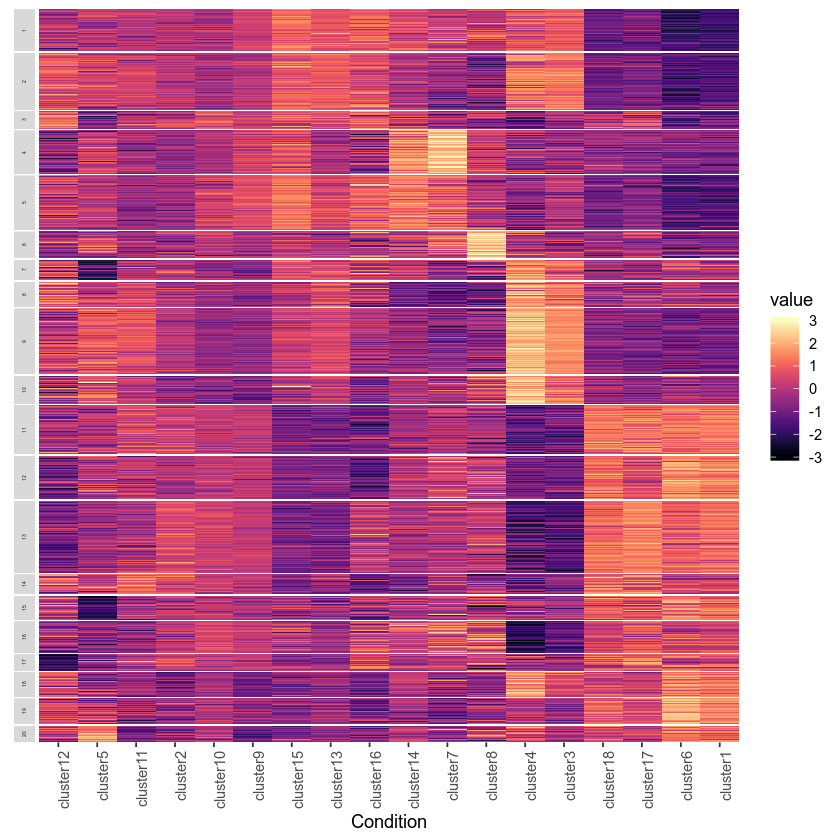

In [176]:
idxs = seq(1, nrow(cts_clustered_col_ordered), 1) # if subsample
ggplot(data = melt(cts_clustered_col_ordered[idxs,]), mapping = aes(x = Var2,
                                                         y = Var1,
                                                         fill = value)) +
geom_tile()  + ylab(NULL) + xlab("Condition") +  
geom_raster(aes(fill=value)) +
scale_fill_viridis(limits=c(-3, 3), oob=squish, option = "A") +
# scale_fill_viridis(option="A") + 
# scale_fill_gradient2(low="red", mid="black", high="blue") +
facet_grid(sort(pr_mb)[idxs] ~ ., switch = "y", scales = "free_y", space = "free_y") +
# theme_classic() +
theme(axis.text.x=element_text(angle=90,hjust=1),
      axis.text.y=element_blank(),
      axis.ticks.y=element_blank(),
      panel.spacing.y = unit(0.03, "cm"),
      strip.text.y = element_text(size = 3))  +
#       strip.background = element_rect(size = 0.1))

ggsave(sprintf("figs/%s_heatmap_idr_znorm_n%d.jpeg", format(Sys.Date(), format='%Y%m%d'), length(table(pr_mb))),
       dpi=1000)

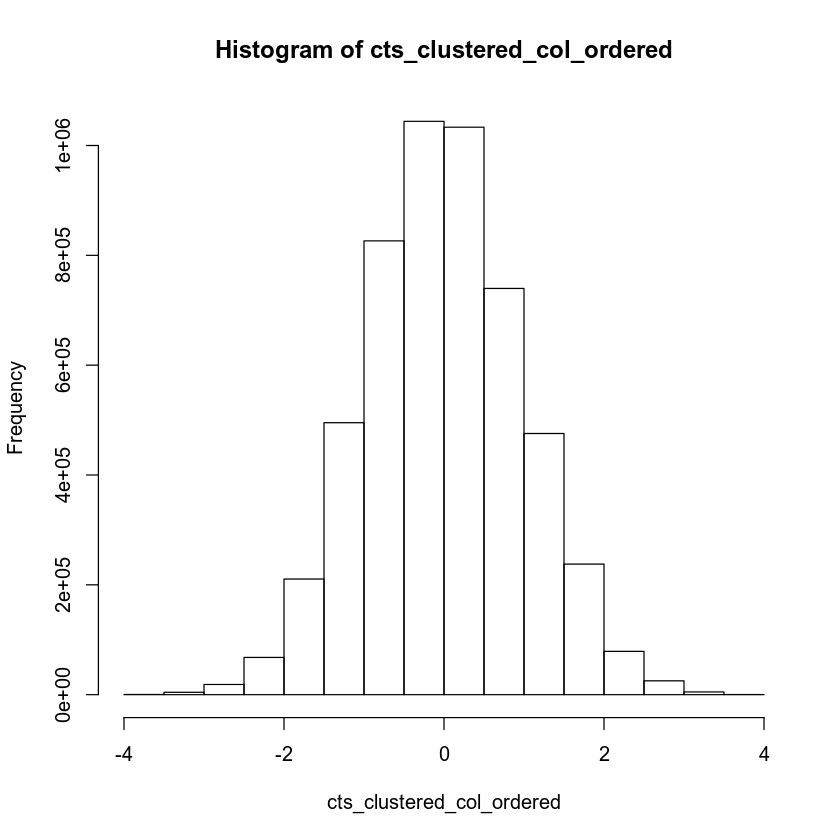

In [140]:
# See distribution of scores
hist(cts_clustered_col_ordered)

In [344]:
plot_lfc <- function(norm_matrix, S1, S2) {
    df = data.frame(y=(norm_matrix[,S1]/norm_matrix[,S2]),
                x=((norm_matrix[,S1]*norm_matrix[,S2])/2))
    p <- ggplot(df, aes(x=log2(x), y=log2(y))) + 
    # geom_point(alpha=0.1) +
    stat_binhex(aes(fill=log(..count..)), bins=100)+
    scale_fill_viridis_c() + 
#     coord_cartesian(xlim=c(0, 8)) +
    geom_abline(slope=0, col="red")
    p
}

# seems like iPSCs have more open sites...check diff peaks!
# plot_lfc(norm_cts, "cluster4", "cluster18")

## Writing BED files for some clusters

In [175]:
CLUSTER_IDX = 1
NORM = 'heatmap_idr_znorm'
BED_PATH = sprintf("beds/%s_%s_n%d/idx%d.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)), CLUSTER_IDX)
# rownames(vsd_assay_to_cluster_normalized)[(which(pr_mb==CLUSTER_IDX))]
BED_PATH

[1] "beds/20200202_heatmap_idr_znorm_n20/idx1.bed"

In [177]:
for (i in seq(1,length(table(pr_mb)))){
BED_PATH = sprintf("beds/%s_%s_n%d/idx%d.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)), i)
fileConn = file(BED_PATH)
writeLines(rownames(cts_to_cluster)[(which(pr_mb==i))], fileConn)
close(fileConn)}

In [178]:
ALL_PEAKS_BED_PATH = sprintf("beds/%s_%s_n%d/all_peaks.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)))
print(ALL_PEAKS_BED_PATH)
fileConn = file(ALL_PEAKS_BED_PATH)
writeLines(rownames(cts_to_cluster), fileConn)
close(fileConn)

[1] "beds/20200202_heatmap_idr_znorm_n20/all_peaks.bed"


Commands for motif analysis:

```EXP=20200130_heatmap_idr_n20; for i in {1..4} ; do if [ ! -d homer/$EXP/idx$i ] ; then findMotifsGenome.pl beds/$EXP/idx$i.bed ~/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta homer/$EXP/idx$i -nomotif -size given -bg beds/$EXP/all_peaks.bed -p 8 ; fi ; done```

## GREAT Analysis

In [59]:
library(rGREAT)


------------------
Note: On Aug 19 2019 GREAT released version 4 where it supports `hg38`
genome and removes some ontologies such pathways. `submitGreatJob()`
still takes `hg19` as default. `hg38` can be specified by the `species
= 'hg38'` argument. To use the older versions such as 3.0.0, specify as
`submitGreatJob(..., version = '3.0.0')`.
------------------


In [251]:
peaks = read.table("beds/20200202_heatmap_idr_znorm_n20/idx10.bed")
colnames(peaks) = c("chr", "start", "end")
peaks = makeGRangesFromDataFrame(peaks)
peaks

GRanges object with 11450 ranges and 0 metadata columns:
          seqnames            ranges strand
             <Rle>         <IRanges>  <Rle>
      [1]     chr1     181029-181260      *
      [2]     chr1     181326-181580      *
      [3]     chr1     629283-630067      *
      [4]     chr1     631001-631377      *
      [5]     chr1     633905-634268      *
      ...      ...               ...    ...
  [11446]     chrY 17579591-17579969      *
  [11447]     chrY 26670528-26670881      *
  [11448]     chrY 26670911-26671111      *
  [11449]     chrY 26671305-26671505      *
  [11450]     chrY 56734685-56734890      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [252]:
bg = read.table("beds/20200202_heatmap_idr_znorm_n20/all_peaks.bed")
colnames(bg) = c("chr", "start", "end")
bg = makeGRangesFromDataFrame(bg)
bg

GRanges object with 292377 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]     chr1       51909-52109      *
       [2]     chr1     180686-181019      *
       [3]     chr1     181029-181260      *
       [4]     chr1     181326-181580      *
       [5]     chr1     191417-191618      *
       ...      ...               ...    ...
  [292373]     chrY 20925381-20925700      *
  [292374]     chrY 26670528-26670881      *
  [292375]     chrY 26670911-26671111      *
  [292376]     chrY 26671305-26671505      *
  [292377]     chrY 56734685-56734890      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [253]:
job = submitGreatJob(peaks, bg = bg, species = "hg38", request_interval = 10)

In [254]:
job

Submit time: 2020-02-02 19:32:37 
Version: 4.0.4 
Species: hg38 
Inputs: 11450 regions
Background: user-defined, 292377 regions
Model: Basal plus extension 
  Proximal: 5 kb upstream, 1 kb downstream,
  plus Distal: up to 1000 kb
Include curated regulatory domains

Enrichment tables for following ontologies have been downloaded:
  None


In [255]:
tb = getEnrichmentTables(job)
names(tb)

[1] "GO Molecular Function" "GO Biological Process" "GO Cellular Component"

In [256]:
head(tb[[2]][tb[[2]]$Hyper_Fold_Enrichment>1, c(1,2,3,4,6,13)], 10)

ID,name,Hyper_Total_Regions,Hyper_Expected,Hyper_Fold_Enrichment,Hyper_Adjp_BH
GO:1901079,positive regulation of relaxation of muscle,38,1.4881470,9.407672,1.033988e-06
GO:0003404,optic vesicle morphogenesis,125,4.8952210,4.698460,3.453053e-06
GO:1901899,positive regulation of relaxation of cardiac muscle,25,0.9790442,11.235450,3.453053e-06
GO:0070473,negative regulation of uterine smooth muscle contraction,97,3.7986910,5.264971,3.453053e-06
GO:0048561,establishment of animal organ orientation,26,1.0182060,10.803320,3.892322e-06
GO:0021903,rostrocaudal neural tube patterning,630,24.6719100,2.350851,6.473699e-06
GO:0007597,"blood coagulation, intrinsic pathway",287,11.2394300,3.114038,7.210991e-06
GO:0071838,cell proliferation in bone marrow,13,0.5091030,15.713910,8.237229e-06
GO:1903597,negative regulation of gap junction assembly,13,0.5091030,15.713910,8.237229e-06
GO:0032811,negative regulation of epinephrine secretion,163,6.3833680,3.916428,8.237229e-06
